# Описание проекта

Рассмотрим показатели развлекательного приложения Procrastinate Pro+. Последние месяцы, несмотря на вложения в рекламу, компания терпит убыткии. Проанализируем данные и выявим причины убытков. Сформируем рекомендации по сокращению убытков компании и поможем компании выйти в плюс.  
Мы имеем данные о пользователях, привлеченных с 1 мая по 27 октября 2019:  
* лог сервера с данными об их посещениях,  
* 
выгрузка их покупок за этот период  
* 
рекламные расходы.


#### Шаг 1. Загрузим данные и подготовим их к анализу

**1.1** Загрузим необходимые для работы библиотеки. Добавим переменные с названиями датасетов.

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta as td
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math


In [2]:
try:    
    visits = pd.read_csv('c:/Users/KVladimir/Desktop/practicum/procrastinate_pro/visits_info_short.csv')  # лог сервера с информацией о посещениях сайта
    orders = pd.read_csv('c:/Users/KVladimir/Desktop/practicum/procrastinate_pro/orders_info_short.csv')  # информация о заказах
    costs = pd.read_csv('c:/Users/KVladimir/Desktop/practicum/procrastinate_pro/costs_info_short.csv')  # информация о расходах на рекламу
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')  # лог сервера с информацией о посещениях сайта
    orders = pd.read_csv('/datasets/orders_info.csv')  # информация о заказах
    costs = pd.read_csv('/datasets/costs_info.csv')  # информация о расходах на рекламу


**1.2** Выполним предобработку данных. Просмотрим первые строки датасета, выведем на экран количество строк и типы данных.

Просмотрим датасет visits

In [3]:
display (visits.info())
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Тип данных в столбцах Session Start, Session End преобразуем в тип datetime, а данные в столбцах Region,Device, Channel в str. 

In [4]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End']) 
visits['Region'] = visits['Region'].astype(str)
visits['Device'] = visits['Device'].astype(str)
visits['Channel'] = visits['Channel'].astype(str)

Переведем названия столбцов в нижний регистр и заменим пробелы на "_".

In [5]:
visits.columns = visits.columns.str.lower()
visits.columns = visits.columns.str.replace(' ', '_')

Проверим столбцы на дубликаты и уникальные значения.

In [6]:
visits[visits.duplicated()]

,user_id,region,device,channel,session_start,session_end


Дубликаты отсутствуют. 

In [7]:
visits['user_id'].nunique()

150008

Имеется 150008 уникальных user_id.

Проверим ошибки в столбце "region".

In [8]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

Имеется информация по 4 странам: 'United States', 'UK', 'France', 'Germany'.

In [9]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

В датасете присутствует информация по 4 устройствам: iPhone, Mac, Android, PC. Ошибок в названии нет. 

Проверим датасет orders.

In [10]:
display (orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Аналогично датасету Visits, изменим тип данных столбца "Event Dt" на datetime и переведем названия в нижний регистр. Заменим пробелы на "_"

In [11]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

Переведем названия столбцов в нижний регистр и заменим пробелы на "_".

In [12]:
orders.columns = orders.columns.str.lower()
orders.columns = orders.columns.str.replace(' ', '_')

Проверим на наличие дубликатов.

In [13]:
orders[orders.duplicated()]

,user_id,event_dt,revenue


Проверим датасет costs.

In [14]:
display (costs.info())
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Изменим тип данных столбца "dt" на datetime и переведем названия в нижний регистр.

In [15]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.columns = costs.columns.str.lower()

Проверим столбец "сhannel" на дубликаты.

In [16]:
display (costs['channel'].unique())
ad_qntity = costs['channel'].nunique() 
print (f'Кол-во рекламных источников - {ad_qntity}')

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Кол-во рекламных источников - 10


В столбце дубликаты отсутствуют.

**Вывод** Загрузим данные и подготовим их к анализу
На этом шаге мы присвоили переменным датасеты с предоставленной информацией. Типы данных в столбцах с датой и временем привели к единому формату. Проверили данные на явные и неявные дубликаты. Посчитали количество уникальных значений. 
    Так мы имеем 150008 уникальных пользователей из 4 стран: США, Англии, Франции и Германии, а также 4 типа устройств которыми они пользуются: iPhone, Android, PC, Mac.

#### Шаг 2. Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

In [17]:
analysis_horizon = 14  # задаем горизонт анализа

# функция получения пользовательских профилей
def get_profiles(sessions, orders, ad_costs):

    # параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # определяем дату первого посещения
    # и первый день месяца, в который посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].dt.month

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # группируем уникальных пользователей
    # по источником и дате привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # группируем затраты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # расчет САС
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [18]:
# функция для подсчёта Retention Rate
def get_retention(
    profiles,
    sessions,
    observation_date,
    analysis_horizon,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в список dimensions 
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - td(
            days=analysis_horizon - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

In [19]:
# функция для подсчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    analysis_horizon,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - td(
            days=analysis_horizon - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, analysis_horizon):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(analysis_horizon))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, analysis_horizon)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], analysis_horizon
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    analysis_horizon,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - td(
            days=analysis_horizon - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, analysis_horizon):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(analysis_horizon))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        #сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(analysis_horizon))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, analysis_horizon
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], analysis_horizon
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time,  
        roi_grouped,  
        roi_in_time,  
    ) 

In [21]:
# функция для сглаживания данных

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [22]:
# функция для построения графика Retention Rate

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [23]:
# функция для построения графика конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [24]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

**Вывод:**  
На втором шаге мы задали функции:  
— для создания профилей пользователей,  
— для подсчёта Retention Rate,  
— для подсчёта конверсии,  
— для подсчёта LTV,  
— для сглаживания данных,  
— для построения графика Retention Rate,  
— для построения графика конверсии,  
— для визуализации LTV и ROI.

#### Шаг 3. Исследовательский анализ данных

**3.1** Составим профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.

In [25]:
profiles = get_profiles(visits, orders, costs)
profiles.head() 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,5,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,7,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,10,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,8,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,10,False,0.230769


In [26]:


min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()
print (f'Минимальная дата привлечения пользователей - {min_analysis_date} \nМаксимальная дата привлечения пользователей - {observation_date}')

Минимальная дата привлечения пользователей - 2019-05-01 00:00:00 
Максимальная дата привлечения пользователей - 2019-10-27 00:00:00


**Вывод**  
Минимальная дата привлечения 1 мая 2019г,  
Максимальная дата привлечения 27 октября 2019г.  
Даты совпадают с заданием.

**3.2** Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [27]:
region_usr = pd.DataFrame()
region_usr['users_cnt'] = profiles.groupby('region')['user_id'].count()
region_usr['share'] = ((region_usr['users_cnt'] / profiles['region'].count()) * 100)
region_usr['payer_users_cnt'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_usr['payer_share'] = ((region_usr['payer_users_cnt'] / region_usr['users_cnt']) * 100)
region_usr.sort_values(by = ['share'], ascending = [False]).style.format({'share': '{:.2f}%','payer_share': '{:.2f}%'})

,users_cnt,share,payer_users_cnt,payer_share
region,,,,
United States,100002,66.66%,6902,6.90%
UK,17575,11.72%,700,3.98%
France,17450,11.63%,663,3.80%
Germany,14981,9.99%,616,4.11%


**Вывод**  
Наибольшее количество пользователей приходит из США - 66.66%,  
на втором месте Великобритания с 11.72%,  
третье место занимает Франция 11.62%,  
четвертое место занимает Германия с 9.99%  
По количеству платящих пользователей: 
 - также лидируют США c 6.9%,
 - на втором месте Германия - 4.11%,
 - на третьем месте Великобритания с 3.98%,
 - на четвертом Франция с 3.8%
                                      

**3.3** Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [28]:
device_usr = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by = 'user_id', ascending = False)
device_usr['dev_share'] = device_usr['payer'] / device_usr['user_id'] * 100
device_usr.drop('payer', axis = 1).style.format({'dev_share': '{:.2f}%'})

,user_id,dev_share
device,,
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%
Mac,30042,6.36%


**Вывод**  
Наиболее популярным устройством среди пользователей сервиса является iphone.  
На втором месте по популярности стоит платформа Android  
Третье место занимает платформа PC  
Наименьшей популярностью пользуется Mac  
Ситуация с платящими пользователями обратная. Наибольшей популярностью среди платящих пользователей обладает Mac, за ней следует iphone, а третье место занимает Android.

**3.4** Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [29]:
channel_usr = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum'})
channel_usr['payer_share'] = channel_usr['payer'] / channel_usr['user_id'] * 100
channel_usr.sort_values(by = 'payer', ascending = False).style.format({'payer_share': '{:.2f}%'})

,user_id,payer,payer_share
channel,,,
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
organic,56439,1160,2.06%
WahooNetBanner,8553,453,5.30%
AdNonSense,3880,440,11.34%
RocketSuperAds,4448,352,7.91%
LeapBob,8553,262,3.06%
OppleCreativeMedia,8605,233,2.71%
lambdaMediaAds,2149,225,10.47%


**Вывод**  
Чаще всего платящие пользователи приходят по каналу FaceBoom.  
Второе место занимает TipTop, а замыкают тройку лидеров пользователи которые пришли на платформу самостоятельно.  
Платящие пользователи чаще всего приходят также по каналу FaceBoom. Второе место занимает AdNonSense, а третье место занимает lambdaMediaAds с 10.46%.

#### Шаг 4. Маркетинг

**4.1** Посчитаем общую сумму расходов на маркетинг.

In [30]:
mrking_cst=costs['costs'].sum().round(1)
print (f'Общая сумма расходов на маркетинг - {mrking_cst}')

Общая сумма расходов на маркетинг - 105497.3


**4.2** Выясним, как траты распределены по рекламным источникам,  сколько денег потратили на каждый источник.

In [31]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending = False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


**Вывод**  
Больше всего средств компания потратила на канал TipTop который не вошел в тройку лидеров по привлечению пользователей. Второе место по затратам на маркетинг заанимает FaceBoom который оправдал затраты. третье место по затратам на рекламу занимает WahooNetBanner. 

**4.3** Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.

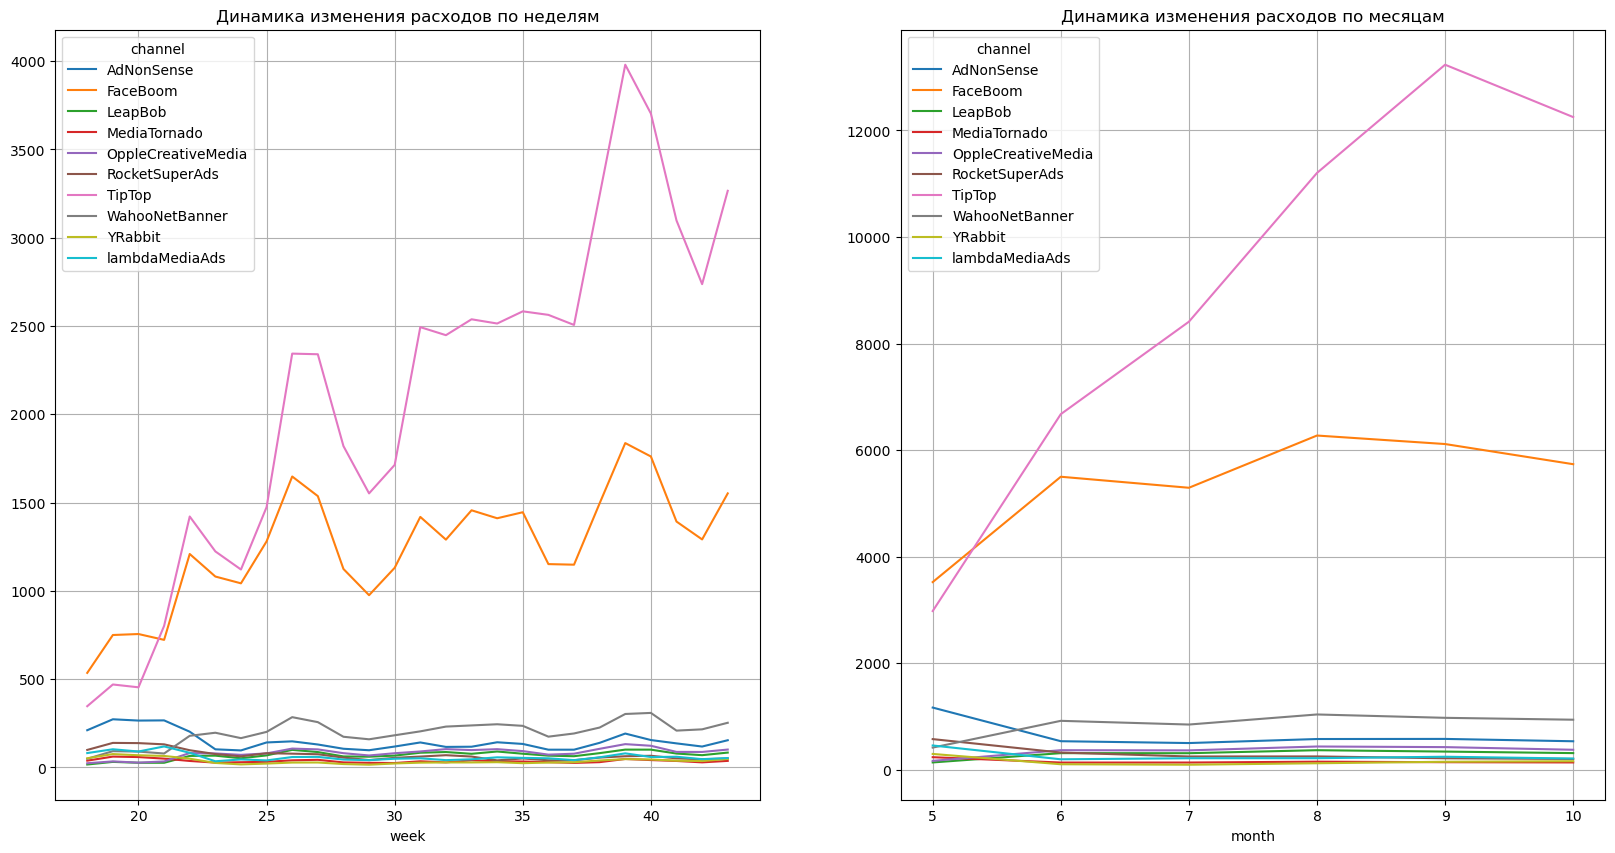

In [32]:
#добавим столбцы с номером недели и месяца
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month
#построим графики
plt.figure(figsize=(20, 10))
costs.pivot_table(index = 'week', columns = 'channel', values = 'costs', aggfunc = 'sum').plot(grid = True, ax = plt.subplot(1, 2, 1))
plt.title('Динамика изменения расходов по неделям')

costs.pivot_table(index = 'month', columns = 'channel', values = 'costs', aggfunc = 'sum').plot(grid = True, ax = plt.subplot(1, 2, 2))
plt.title('Динамика изменения расходов по месяцам')
plt.show()

**Вывод**  
По графикам выделяются лидеры FaceBoom и TipTop. Эти каналы лидируют по затратам.

**4.4** Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

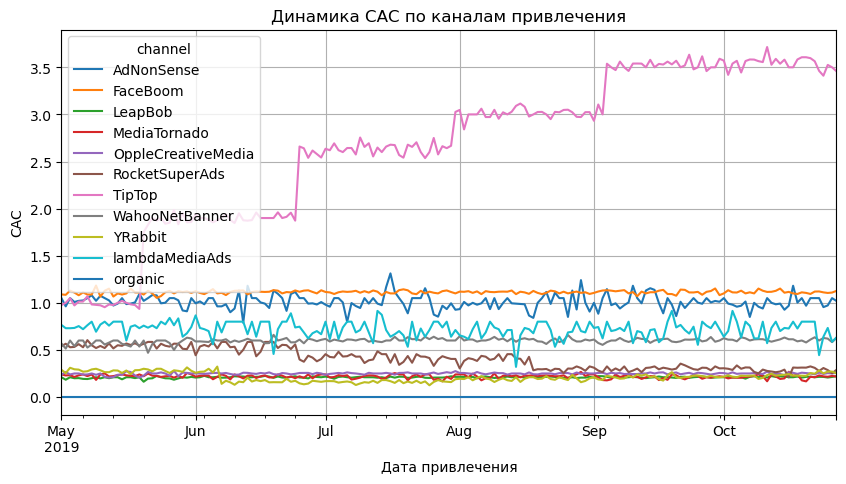

In [33]:
profiles.pivot_table(index='dt', 
                     columns='channel', values='acquisition_cost',
                     aggfunc='mean').plot(grid=True,
                                          figsize=(10, 5))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

In [34]:
cac_prfiles = profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).mean().sort_values(ascending = False)

display (cac_prfiles)

channel
TipTop                2.655599
FaceBoom              1.112864
AdNonSense            1.010467
lambdaMediaAds        0.721029
WahooNetBanner        0.599336
RocketSuperAds        0.406634
OppleCreativeMedia    0.249327
MediaTornado          0.218692
YRabbit               0.211194
LeapBob               0.209443
organic               0.000000
dtype: float64

**Вывод**  
Общая сумма расходов на маркетинг - 105497. Больше всего средств компания потратила на канал TipTop который не вошел в тройку лидеров по привлечению пользователей. Второе место по затратам на маркетинг заанимает FaceBoom который оправдал затраты. третье место по затратам на рекламу занимает WahooNetBanner. Самая высокая стоимость привлечения пользователя у TipTop = 2.66. И по этому каналу стоимость больше всего выросла относительно других каналов. Самыме дорогие по стоимости привлечения каналы: TipTop, FaceBoom, AdNonSense.

#### Шаг 5. Оценка окупаемости рекламы

**5.1** Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

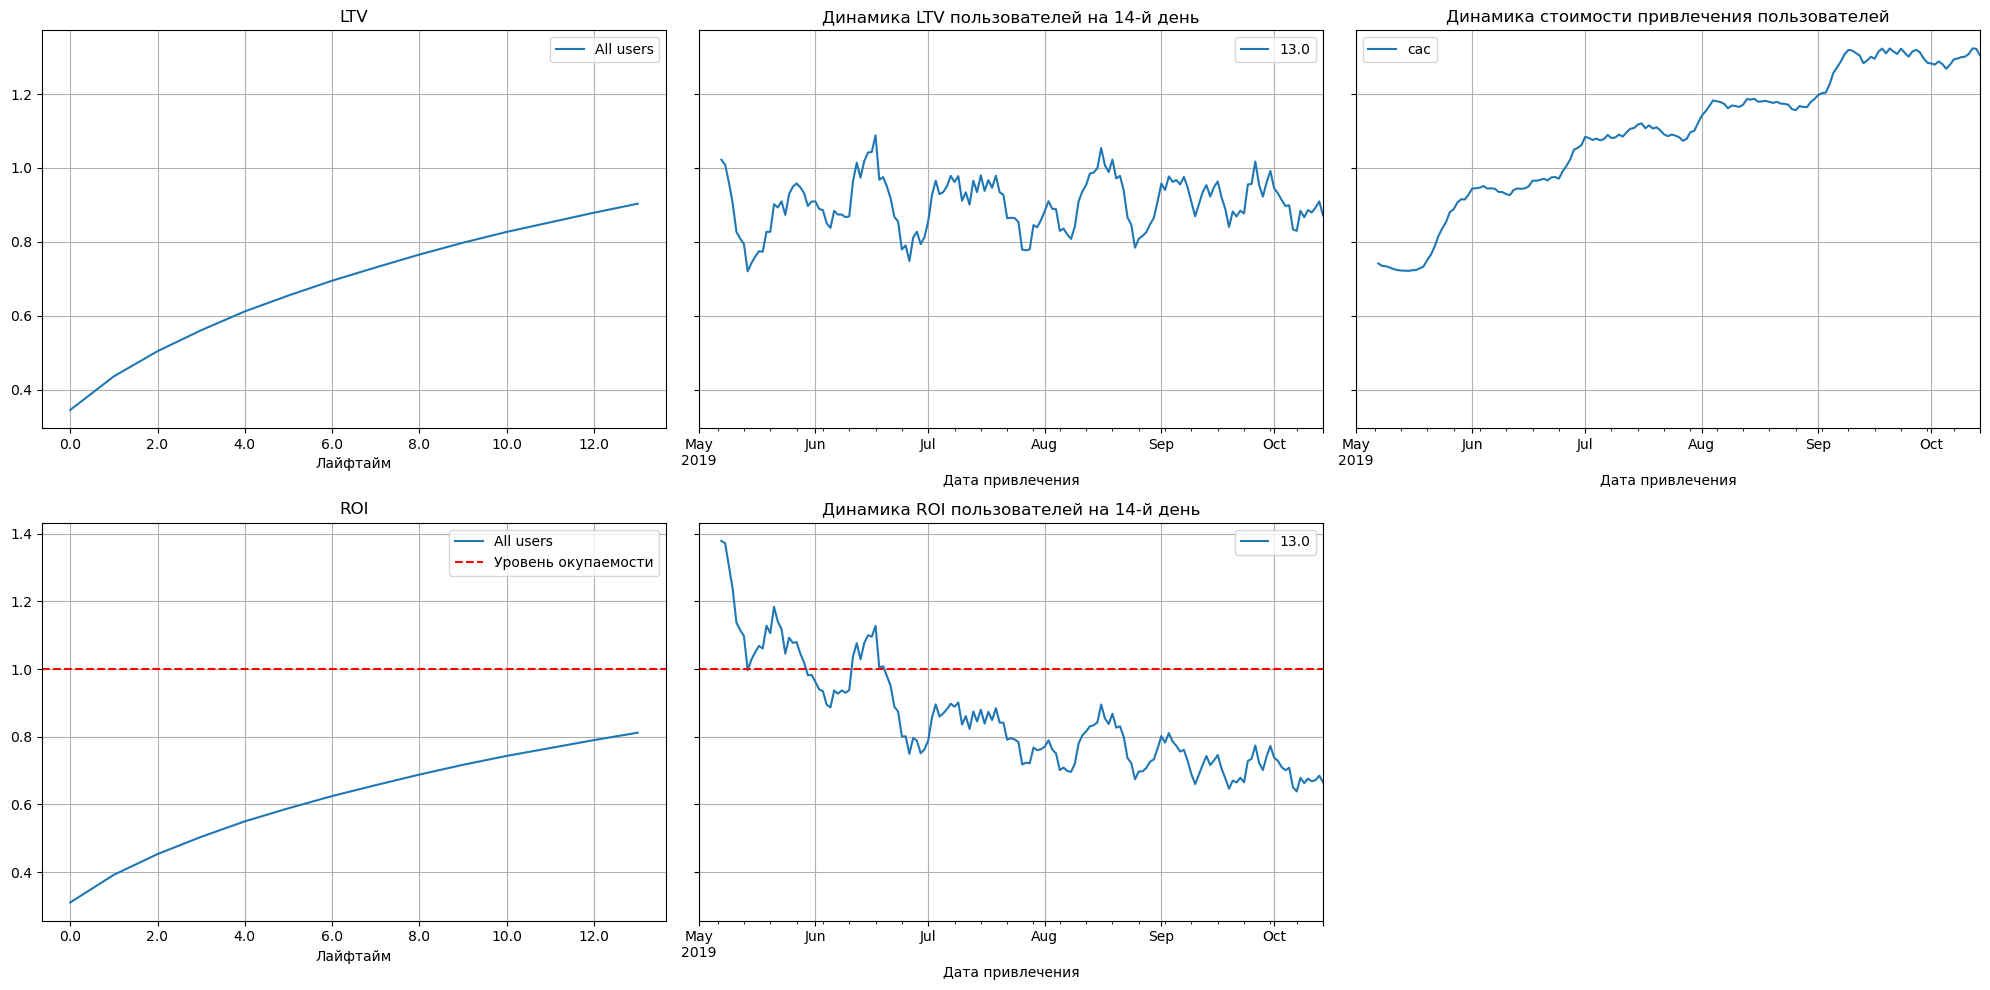

In [35]:
# убираем органических пользователей привлечение которых ничего компании не стоило 
profiles = profiles.query('channel != "organic"') 

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

**Вывод**
 - LTV достаточно стабилен. 
 - CAC нестабилен. Стоимость привлечения клиентов растет с течением времени
 - ROI — чуть выше 80%
 - К концу периода реклама не окупается
 - ROI постоянно снижается. К концу июня показатель стабильно ушел ниже линии окупаемости, а к концу периода снизился до 0.6.

**5.2** Проверим конверсию пользователей и динамику её изменения. Проверим удержание пользователей. Построим и изучим графики конверсии и удержания.

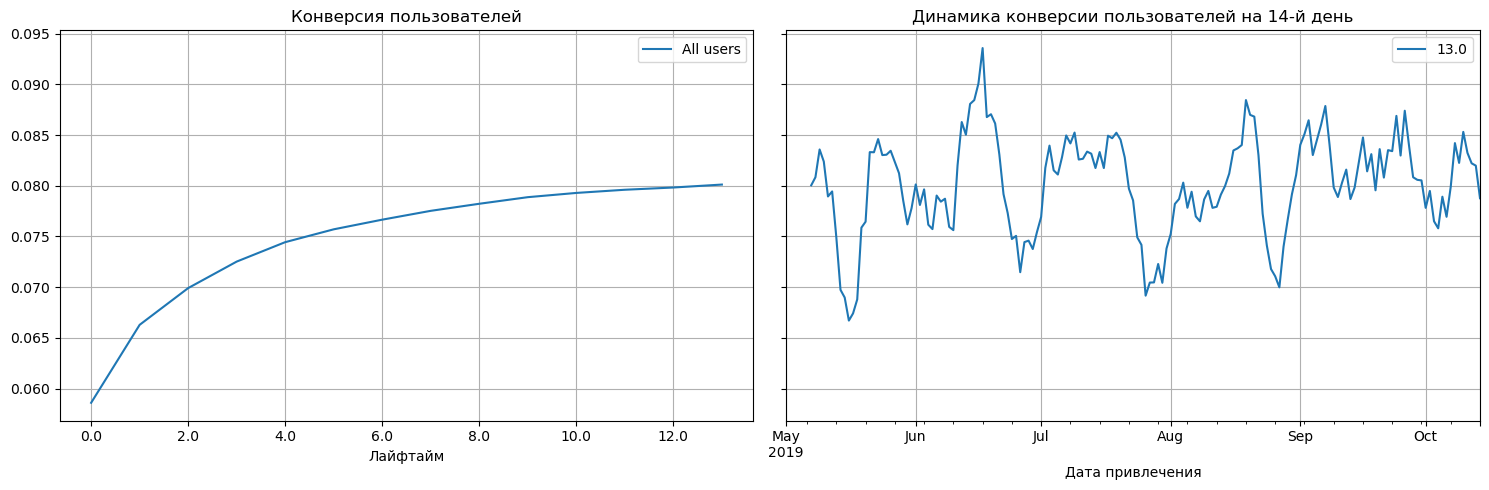

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon) 

**Вывод**  
График конверсии стабильный, имеет постоянный рост.

**5.3** Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

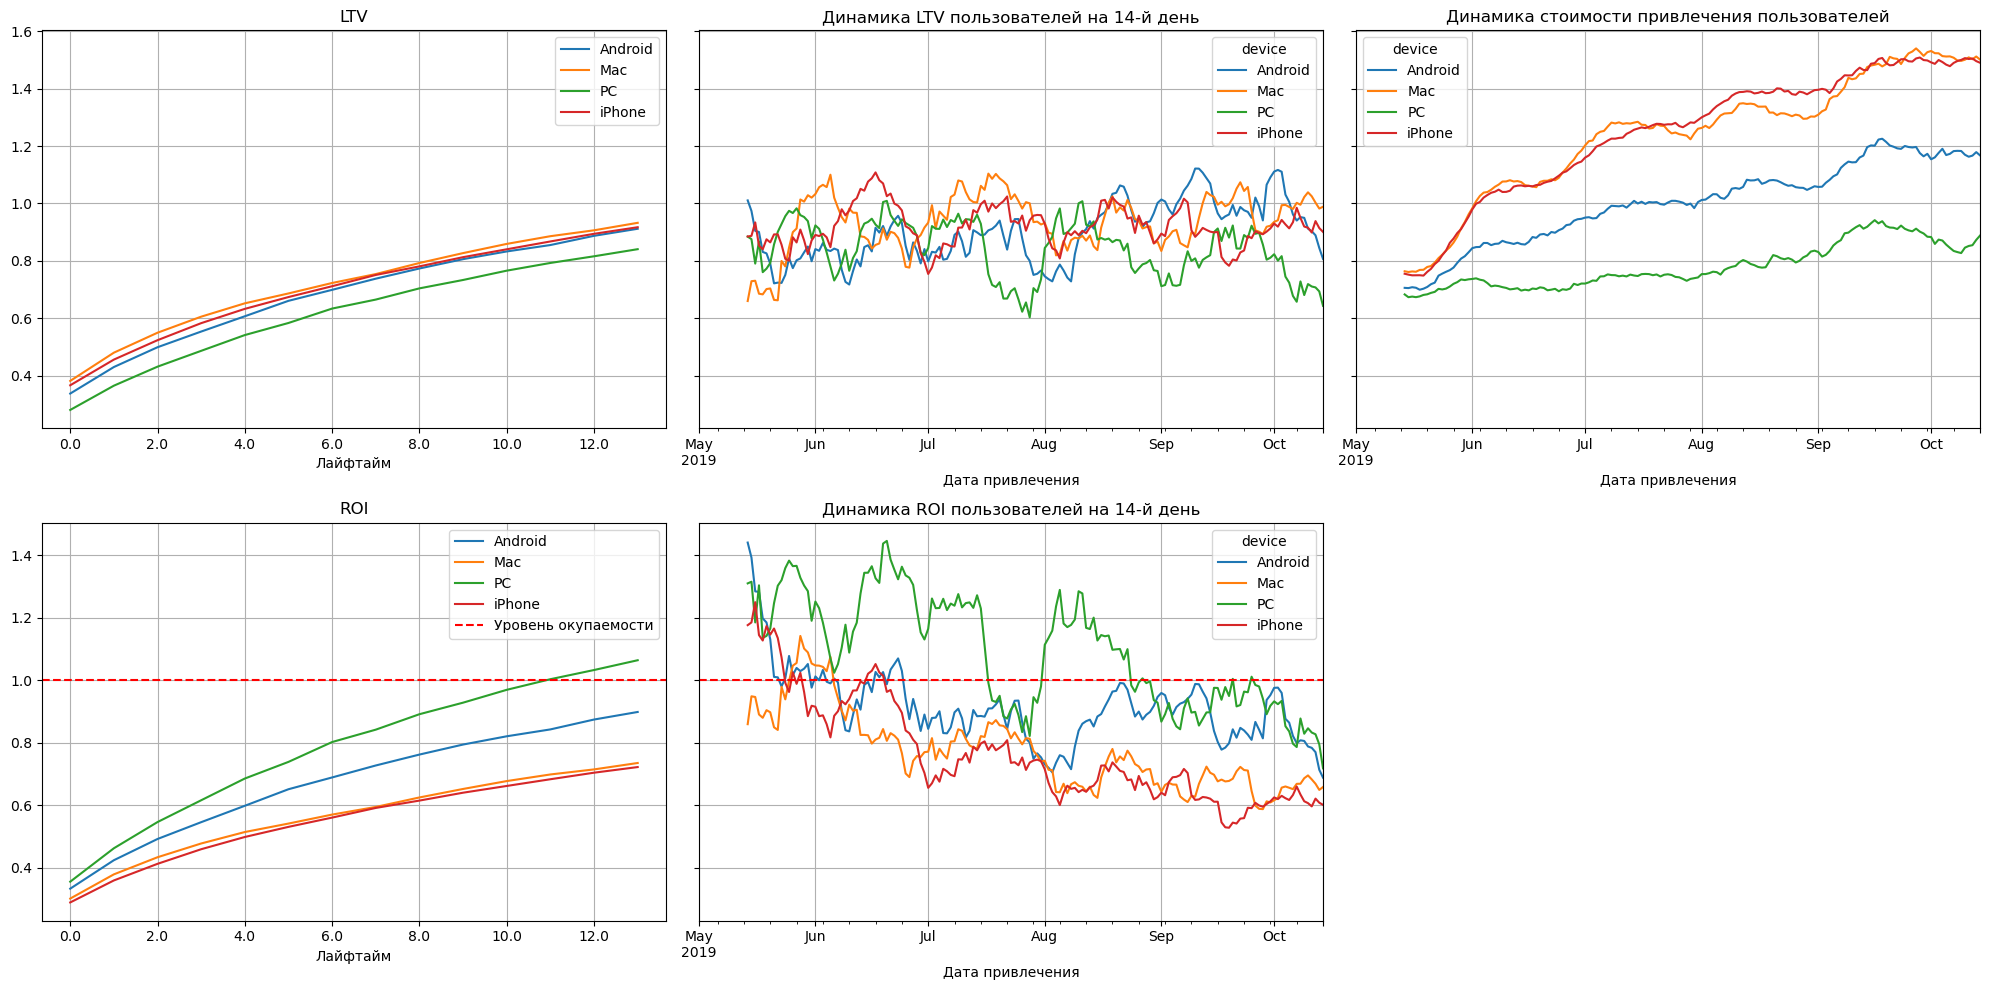

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions= ['device'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14) 

**Вывод**  
LTV пользователей стабилен. Стоимость привлечения пользователей PC самая низкая, а ROI наоборот самый высокий. Стоимость привлечения пользователей растет, при этом стоимость привлечения пользователей PC все также ниже остальных. 

До июня окупаемость пользователей была хорошей. В июне что-то произошло, что привело к снижению возврата инвестиций от всех пользователей. Для пользователей PC негативный фактор оказался не настолько критичным в краткосрочной перспективе, но в начале августа и среди них произошло снижение. Уже к началу сентября пользователи PC перешагнули порог окупаемости. 
Окупаемость пользователей mac, android и iphone уже после июля был ниже порога окупаемости.

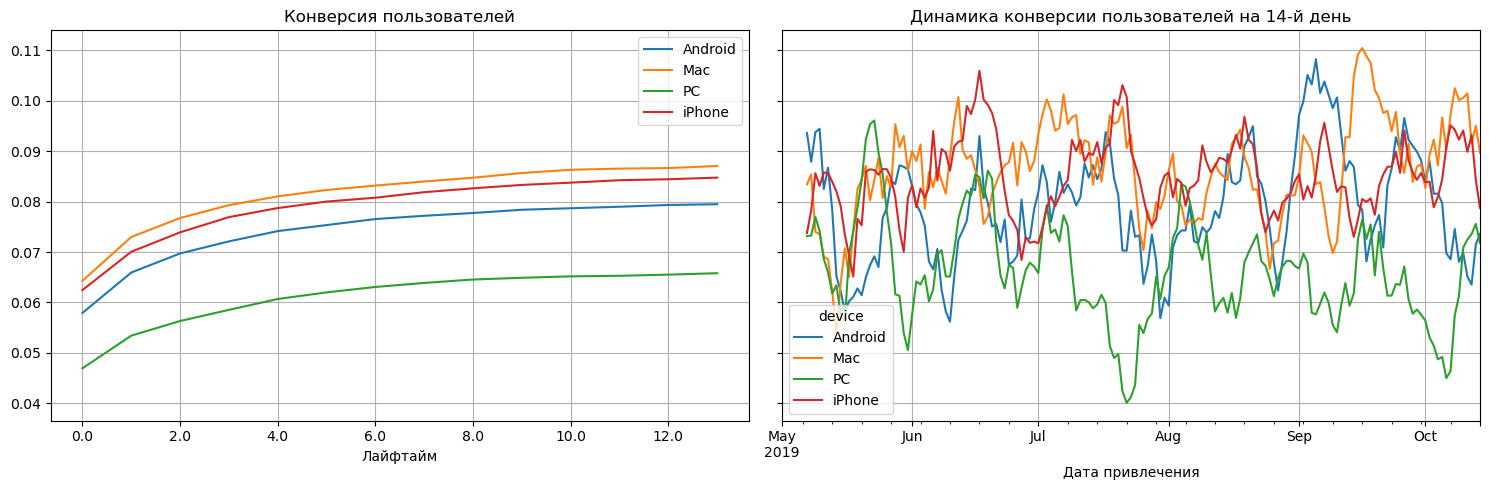

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon) 

**Вывод**  
Mac, Android и iPhone конвертируются стабильно. 

**5.4** Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

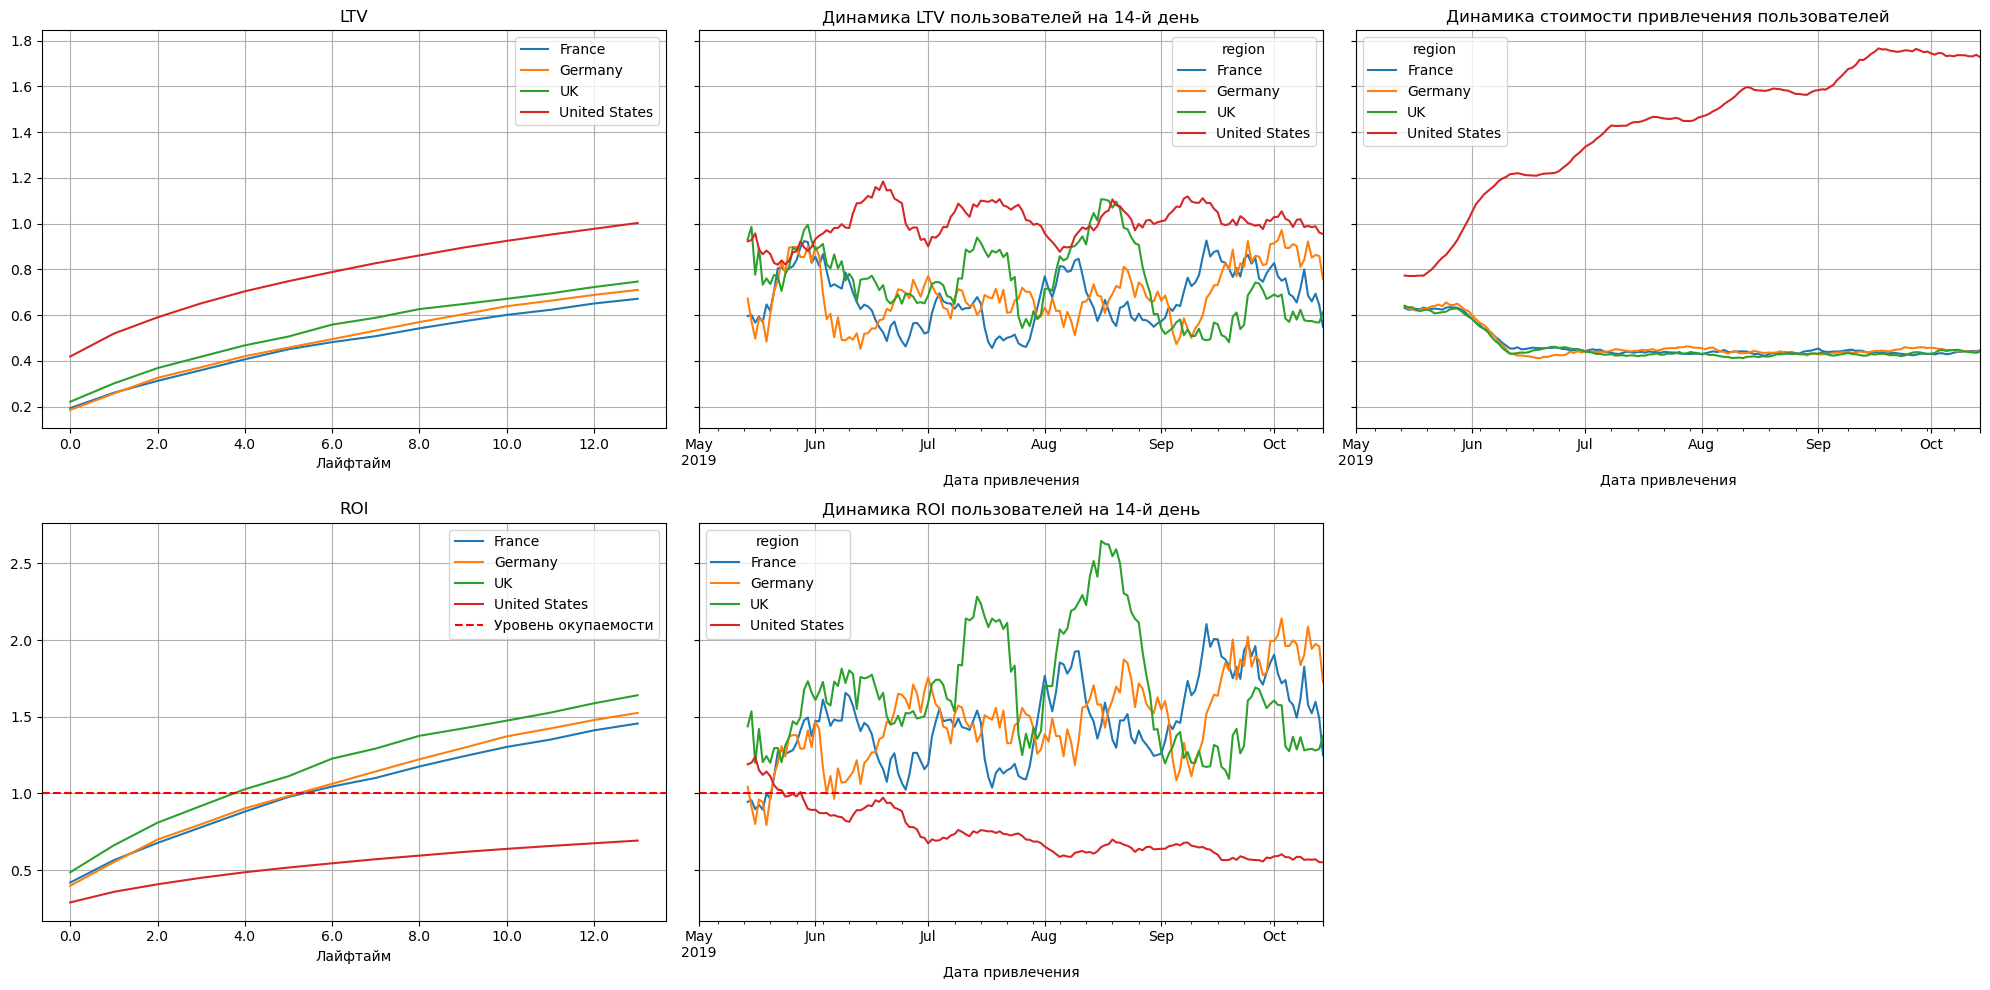

In [39]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
)

**Вывод**  
Пользователи из USA являются самой многочисленной, но и их привлечение обходится дороже остальных. Стоимость привлечения пользователя из USA почти в 4 раза выше стоимости привлечения пользователей из других регионов. Причем окупаемость пользователей из USA к концу 14 дня составляет около 70%

**5.5** Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

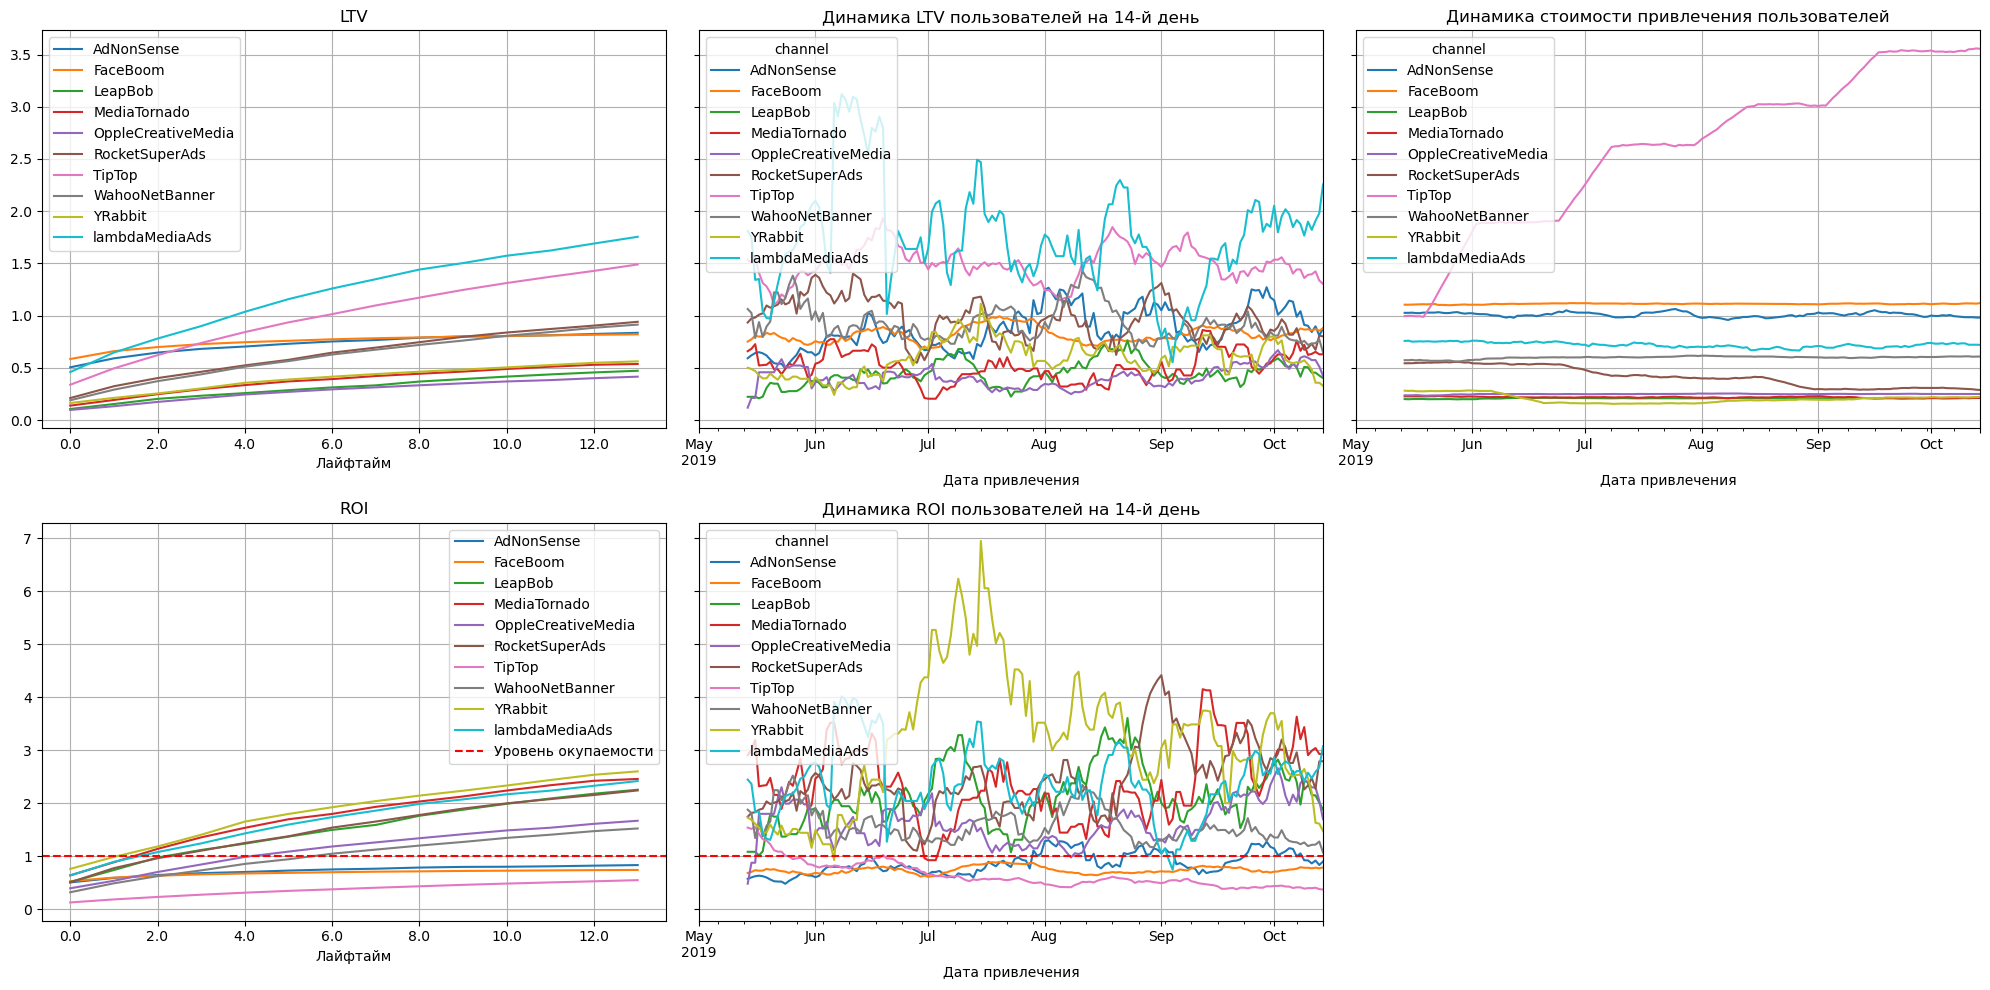

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date,
                                                                      analysis_horizon, dimensions= ['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14)

**Вывод**  
По каналу TipTop постоянно растет стоимость привлечения пользователей, хотя эти вложения и не окупаются. Пользователи пришедшие по каналам TipTop, FaceBoom и AdNonSence не окупаются за 14 дней.  
Пользователи привлеченные по каналу YRabbit в июле показали хороший возврат инвестиций. И в целом их ROI выше порога окупаемости.

**5.6** Ответы на вопросы:

 - Окупается ли реклама, направленная на привлечение пользователей в целом?  
   Реклама близка к окупаемости. По заданию сейчас 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения и то, что в анализ включены органические пользователи. Реклама почти окупается.
 - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?  
 Пользователи из США с устройствами iphone и Mac могут снижать окупаемость. Затраты на рекламные каналы LeapBop, FaceBoom, TipTop не оправдали себя. Их ROI ниже уровня окупаемости.
 - Чем могут быть вызваны проблемы окупаемости?  
 Возможно причина в неравномерно распределенном рекламном бюджете. В одни источники вложены большие суммы, а пользователи пришедшие от этих источников не приносят достаточной для окупаемости прибыли. 

#### Шаг 6. Выводы

**6.1** Причины неэффективности привлечения пользователей

1. Реклама в целом не окупается. Причина в повышенных затратах на направления которые не окупаются.  
2. Привлечение пользователей из USA обходится дороже, в несколько раз дороже других регионов, а окупаются они плохо.  
3. Пользователи iphone и Mac также обходятся дороже чем пользователи android и PC.  
4. Пользователи пришедшие с каналов  TipTop, FaceBoom и AdNonSence не окупаются, а затраты на их привлечение велики.  

**6.2** Рекомендации для отдела маркетинга.

1. Обратить внимание на пользователей Android и PC
2. Привлекать пользователей из регионов UK, France и Germany. Их привлечение и удержание обходится дешевле.
3. Отказаться от рекламных каналов FaceBoom, TipTop. Затраты на эти компании велики, а возврат инвестиций они не обеспечивают. 